In [6]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):

    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x



In [8]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "emb_dim": 768,
    "context_length": 1024,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
}


In [12]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [37]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [38]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) 
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [39]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:", mean)
print("Variance:", var)

Mean: tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [40]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized Output:", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean after normalization:", mean)
print("Variance after normalization:", var)

Normalized Output: tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean after normalization: tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance after normalization: tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [41]:
torch.set_printoptions(sci_mode=False)
print("Mean: \n", mean)
print("Variance: \n", var)


Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [42]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # 正規化時に0除算を防ぐために分散に加算される小さな定数
        self.scale = nn.Parameter(torch.ones(emb_dim)) # 訓練可能なパラメータ
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # 訓練可能なパラメータ

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False) # 埋め込み次元nが非常に大きいため、分散の計算で不偏推定を使用しない
        normalized_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * normalized_x + self.shift


In [43]:
ln = LayerNorm(5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("LayerNorm Mean:\n", mean)
print("LayerNorm Variance:\n", var)

LayerNorm Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
LayerNorm Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [44]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

RuntimeError: Numpy is not available

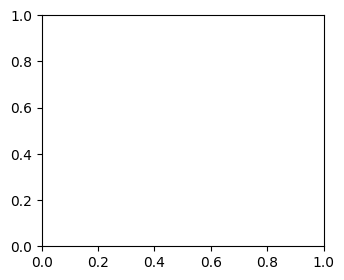

In [ ]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x,y)
    plt.title(f"{label} Activatiodn Function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [49]:
ffn = FeedForward(GPT_CONFIG_124M)

x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [50]:
class ExampleDeepNeuralNetowrk(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut

        self.layers = nn.ModuleList([ # 5つの層を実装
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),

        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape: # ショートカットを適用できるかcheck
                x = x + layer_output
            else:
                x = layer_output
        return x


In [54]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetowrk(layer_sizes, use_shortcut=False)


In [55]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target) # outputとtargetがどれくらい近いかに基づいて損失関数を計算

    loss.backward() # 勾配を計算

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [56]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


In [57]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetowrk(layer_sizes, use_shortcut=True)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


In [3]:
import os
os.getcwd()  # 現在の作業ディレクトリを取得

'/Users/takatorisatoshi/Desktop/playground/tiny-llm/notebooks'

In [4]:
import sys
# 1つ上の階層 (project/) を sys.path に追加
sys.path.append("..")

In [10]:
from tiny_llm.transormer_block import TransformerBlock

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
outpout = block(x)

print("Input shape:", x.shape)
print("Output shape:", outpout.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [28]:
from tiny_llm.gpt_model import GPTModel

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("Output logits shape:", out.shape)
print(out)


Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output logits shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [29]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [20]:
print(f"Token embdding layer shape:",  model.tok_emb.weight.shape)
print(f"Output layer shape:", model.out_head.weight.shape)

Token embdding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [26]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)

print(
    f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: -36,237,312


In [25]:
block = TransformerBlock(GPT_CONFIG_124M)

total_params = sum(p.numel() for p in block.ff.parameters())
print(f"Total number of parameters in FeedForward layer: {total_params:,}")

total_params = sum(p.numel() for p in block.att.parameters())
print(f"Total number of parameters in Attention layer: {total_params:,}")

Total number of parameters in FeedForward layer: 4,722,432
Total number of parameters in Attention layer: 2,360,064


In [31]:
total_size_bytes = total_params * 4 #　合計サイズをバイト数で計算(パラメータひとつあたり4バイトのfloat32と仮定)
total_size_mb = total_size_bytes / (1024 * 1024)  
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [35]:
from tiny_llm.config import GPT_CONFIG_MEDIUM, GPT_CONFIG_LARGE, GPT_CONFIG_XL

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_MEDIUM)

print("Medium model total parameters:", sum(p.numel() for p in model.parameters()))

model = GPTModel(GPT_CONFIG_LARGE)
print("Large model total parameters:", sum(p.numel() for p in model.parameters()))

model = GPTModel(GPT_CONFIG_XL)
print("XLarge model total parameters:", sum(p.numel() for p in model.parameters()))


Medium model total parameters: 406212608
Large model total parameters: 838220800
XLarge model total parameters: 1637792000


In [36]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # idxの形状はコンテキストに対応するインデックスの(batch, n_token)配列    

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # サポートされているコンテキストサイズを超える場合は現在のコンテキストを切り詰める。例えば、LLMがトークンを5つだけサポートしていて、コンテキストのサイズが10の場合は、最後の5つのトークンのみを使用する
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]  # 最後のタイムステップのみに着目し、(batch, n_token, vocab_size)が(batch, vocab_size)になるようにする

        probas = torch.softmax(logits, dim=-1)  # 確率分布に変換 probasの形状は(batch, vocab_size)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # idx_nextの形状は(batch, 1)

        idx = torch.cat((idx, idx_next), dim=1)  # サンプリングしたインデックスを実行中のシーケンスに追加。idxの形状は(batch, n_token+1)になる

    return idx

In [39]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # バッチ次元を追加
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [41]:
model.eval() # 訓練時にのみ使われるドロップアウトのようなランダムなコンポーネントを無効にする

out = generate_text_simple(
    model= model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 17775, 22611, 50121, 45688, 36744, 46811]])
Output length: 10


In [43]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am minimize firefightersfightsmissing hamstring Townsend


In [44]:
from tiny_llm.config import GPT_CONFIG_124M

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

model.eval() # 訓練時にのみ使われるドロップアウトのようなランダムなコンポーネントを無効にする

out = generate_text_simple(
    model= model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10
Hello, I am Featureiman Byeswickattribute argue
